In [20]:
import cv2
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
from sklearn.model_selection import train_test_split
from PIL import Image

In [21]:
# resize images
for name in os.listdir(os.path.join('./heatmap_ML3/foot/')):
    #print(name)
    foot_img = Image.open(os.path.join('./heatmap_ML3/foot/', name))
    shell_img = Image.open(os.path.join('./heatmap_ML3/shell/', name))
    resize_foot = foot_img.resize((256,256))
    resize_foot.save(os.path.join('./ML_heatmaps/foot/', name))
    resize_shell = shell_img.resize((256,256))
    resize_shell.save(os.path.join('./ML_heatmaps/shell/', name))

In [22]:
# Create train/validation/ test dataset
foot_imgs = []
shell_imgs = []
for name in os.listdir(os.path.join('./ML_heatmaps/foot/')):
    #print(name)
    foot_img = cv2.imread(os.path.join('./ML_heatmaps/foot/', name))
    shell_img = cv2.imread(os.path.join('./ML_heatmaps/shell/', name))
    foot_imgs.append(foot_img)
    shell_imgs.append(shell_img)
    
foot_imgs = np.array(foot_imgs)
shell_imgs = np.array(shell_imgs)
# Random train/test split
# X_train, X_test, y_train, y_test = train_test_split(foot_imgs, shell_imgs, test_size=0.20, random_state=42)

idx = int(len(foot_imgs)*0.20)
print(idx)
train_imgs_idx = random.sample(range(0, len(foot_imgs)), len(foot_imgs)-idx)

test_imgs_idx = list(set(range(0, len(foot_imgs))) - set(train_imgs_idx))

X_train = foot_imgs[train_imgs_idx]
y_train = shell_imgs[train_imgs_idx]
X_test = foot_imgs[test_imgs_idx]
y_test = shell_imgs[test_imgs_idx]

230


In [23]:
TRAIN_LENGTH = X_train.shape[0]
BATCH_SIZE = 1
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [24]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Foot Image', 'True Shell Image', 'Predicted Shell Image']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

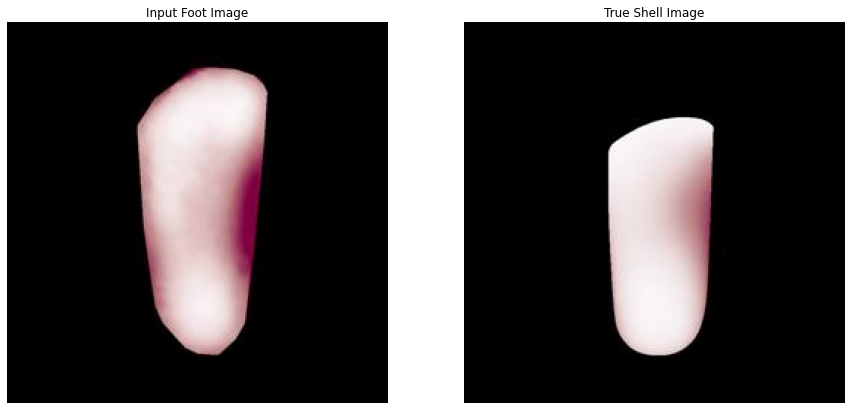

In [25]:
for image, mask in zip(X_test, y_test):
  sample_image, sample_mask = image, mask
  break
display([sample_image, sample_mask])

In [26]:
OUTPUT_CHANNELS = 3

In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [36]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256,256,3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [29]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [37]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[256,256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [38]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_4 (Functional)            [(None, 128, 128, 96 1841984     input_6[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, None, None, 5 1476608     model_4[0][4]                    
__________________________________________________________________________________________________
concatenate_8 (Concatenate)     (None, 16, 16, 1088) 0           sequential_4[1][0]               
                                                                 model_4[0][3]              

In [41]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [42]:
def show_predictions(dataset=None, num=0, train=True):
  if dataset:
    for image, mask in zip(dataset[0], dataset[1]):
      print(mask.shape)
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    if train:
      display([X_train[num], y_train[num],
             create_mask(model.predict(X_train[num][tf.newaxis, ...]))])
    else:
      display([X_test[num], y_test[num],
             create_mask(model.predict(X_test[num][tf.newaxis, ...]))])

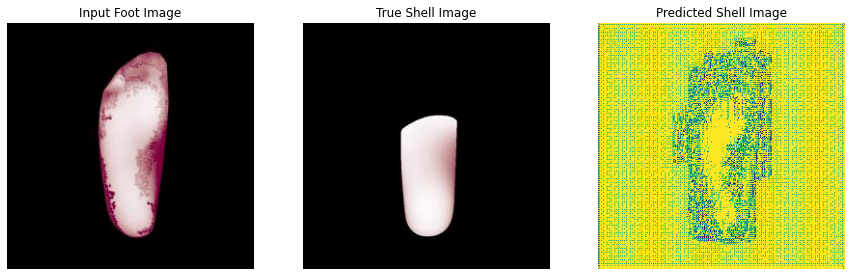

In [43]:
show_predictions(num=1)

In [44]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [45]:
print(y_train.shape)

(924, 256, 256, 3)


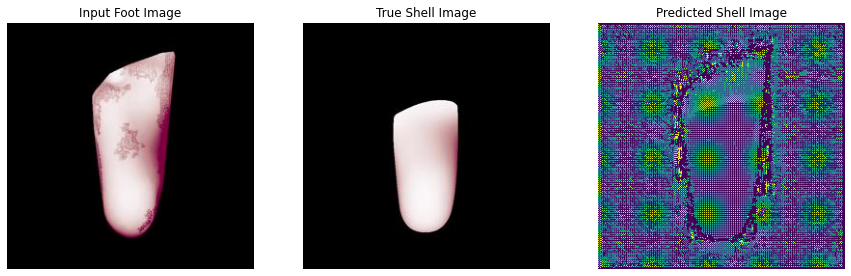


Sample Prediction after epoch 15


Epoch 00015: val_accuracy did not improve from 0.69680


In [46]:
EPOCHS = 15
VAL_SUBSPLITS = 1
VAL_EXAMPLES = X_test.shape[0]
VALIDATION_STEPS = VAL_EXAMPLES//BATCH_SIZE//VAL_SUBSPLITS

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
cp = tf.keras.callbacks.ModelCheckpoint('./ML/', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
tb = tf.keras.callbacks.TensorBoard(log_dir="./logs")


model_history = model.fit(X_train, y_train, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_test, y_test),
                          callbacks=[DisplayCallback(), es, cp, tb])

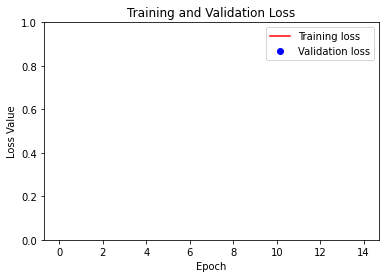

In [53]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

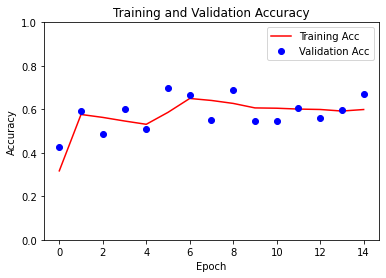

In [54]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

plt.figure()
plt.plot(model_history.epoch, acc, 'r', label='Training Acc')
plt.plot(model_history.epoch, val_acc, 'bo', label='Validation Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Prediction

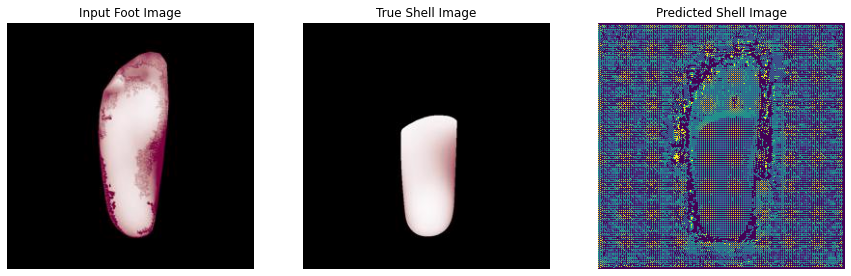

In [55]:
show_predictions(num=1, train=True)

In [58]:
def save_pred(f_name, foot_img):
    pred = np.array(create_mask(model.predict(foot_img[tf.newaxis, ...])))
    pred[np.where(pred != 0)] = 255
    cv2.imwrite(f_name, pred)

In [59]:
num = len(foot_imgs)

for foot_img in foot_imgs:
    save_pred('./prediction/test.jpg', foot_img)
    break

In [52]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model, load_model